### Моделирование и предсказание поведения агентов финансовых систем

#### Лабораторная 2

Глеб Блазнов

##### Загрузка и чтение данных

In [1]:
!pip install -q kaggle

In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"giblaznov","key":"21b93b19719eca401a1d905b383576e9"}'}

In [3]:
!mkdir ~/.kaggle

In [4]:
!cp kaggle.json ~/.kaggle/

In [5]:
!mkdir /content/kaggle

In [6]:
!cp kaggle.json /content/kaggle

In [7]:
!chmod 600 /content/kaggle/kaggle.json
!chmod 600 /root/.kaggle/kaggle.json

In [8]:
!kaggle datasets list

ref                                                            title                                                size  lastUpdated          downloadCount  voteCount  usabilityRating  
-------------------------------------------------------------  --------------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
iamsouravbanerjee/world-population-dataset                     World Population Dataset                             17KB  2022-08-31 11:20:04          10304        306  1.0              
thedevastator/mcdonalds-ice-cream-machines-broken-timeseries   McDonalds Ice Cream Machines Breaking - Timeseries  404KB  2022-09-14 23:51:09           1011         38  1.0              
pantanjali/unemployment-dataset                                Unemployment dataset                                 17KB  2022-09-08 08:26:10           2655         74  1.0              
evangower/premier-league-match-data                            Pr

In [9]:
!kaggle datasets download -d sokolovaleks/alfabattle2-sandbox

100% 4.86G/4.86G [00:42<00:00, 96.4MB/s]
100% 4.86G/4.86G [00:42<00:00, 123MB/s] 


In [10]:
!mkdir /content/alfabattle_data

In [11]:
!unzip alfabattle2-sandbox.zip -d alfabattle_data

Archive:  alfabattle2-sandbox.zip
  inflating: alfabattle_data/alfabattle2_sand_alfabattle2_alpha_sample (1).csv  
  inflating: alfabattle_data/alfabattle2_sand_alfabattle2_test_target_contest.csv  
  inflating: alfabattle_data/alfabattle2_sand_alfabattle2_test_transactions_contest/test_transactions_contest/part_000_1063620_to_1074462.parquet  
  inflating: alfabattle_data/alfabattle2_sand_alfabattle2_test_transactions_contest/test_transactions_contest/part_001_1074463_to_1085303.parquet  
  inflating: alfabattle_data/alfabattle2_sand_alfabattle2_test_transactions_contest/test_transactions_contest/part_002_1085304_to_1095174.parquet  
  inflating: alfabattle_data/alfabattle2_sand_alfabattle2_test_transactions_contest/test_transactions_contest/part_003_1095175_to_1105002.parquet  
  inflating: alfabattle_data/alfabattle2_sand_alfabattle2_test_transactions_contest/test_transactions_contest/part_004_1105003_to_1116054.parquet  
  inflating: alfabattle_data/alfabattle2_sand_alfabattle2_tes

In [12]:
!pip install umap-learn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 88 kB 4.2 MB/s 
     |████████████████████████████████| 1.1 MB 16.5 MB/s 
  Created wheel for umap-learn: filename=umap_learn-0.5.3-py3-none-any.whl size=82829 sha256=72649f9819c910e7651166e61dc6000c34073c93588af3b12a67521004267b3e
  Stored in directory: /root/.cache/pip/wheels/b3/52/a5/1fd9e3e76a7ab34f134c07469cd6f16e27ef3a37aeff1fe821
  Created wheel for pynndescent: filename=pynndescent-0.5.7-py3-none-any.whl size=54286 sha256=6c331797997ab945bda91b2f23b97cb6dcf9d748603b327f62c3b0546382011e
  Stored in directory: /root/.cache/pip/wheels/7f/2a/f8/7bd5dcec71bd5c669f6f574db3113513696b98f3f9b51f496c
Successfully built umap-learn pynndescent


In [13]:
import pandas as pd
import pandas_profiling
import tqdm

import os
import gc
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
import matplotlib.pyplot as plt
import umap
%pylab inline

pd.set_option('display.max_columns', None)

Populating the interactive namespace from numpy and matplotlib


In [14]:
PATH_TO_TRAIN_TARGET = '/content/alfabattle_data/alfabattle2_sand_alfabattle2_train_target.csv'
PATH_TO_TEST_TARGET = '/content/alfabattle_data/alfabattle2_sand_alfabattle2_test_target_contest.csv'

PATH_TO_TRAIN = '/content/alfabattle_data/alfabattle2_sand_alfabattle2_train_transactions_contest/train_transactions_contest'
PATH_TO_TEST = '/content/alfabattle_data/alfabattle2_sand_alfabattle2_test_transactions_contest/test_transactions_contest'

In [15]:
def read_parquet_dataset_from_local(path_to_dataset: str, 
                                    start_from: int = 0,
                                    num_parts_to_read: int = 2, 
                                    columns=None, 
                                    verbose=False,
                                    info_num_parts=False) -> pd.DataFrame:
    """
    читает num_parts_to_read партиций, преобразует их к pd.DataFrame и возвращает
    :param path_to_dataset: путь до директории с партициями
    :param start_from: номер партиции, с которой начать чтение
    :param num_parts_to_read: количество партиций, которые требуется прочитать
    :param columns: список колонок, которые нужно прочитать из партиции
    :return: pd.DataFrame
    """

    res = []
    list_paths = sorted([os.path.join(path_to_dataset, filename) for filename in os.listdir(path_to_dataset) 
                              if filename.startswith('part')])
    if info_num_parts:
        print(f'Кол-во партиций в папке: {len(list_paths)}')
    start_from = max(0, start_from)
    list_path_to_partitions = list_paths[start_from: start_from + num_parts_to_read]
    if verbose:
        print('Reading chunks:\n')
        for path_to_partition in list_path_to_partitions:
            print(path_to_pirtition)
    for path_to_parquet in tqdm.tqdm_notebook(list_path_to_partitions, 
                                              desc="Читаем файлы:"):
        temp_parquet = pd.read_parquet(path_to_parquet,columns=columns)
        res.append(temp_parquet)
        del temp_parquet
        gc.collect()
    return pd.concat(res).reset_index(drop=True)

Прочитаем все файлы из обучающей выборки и сразу преобразуем переменные в формат, который будет подаваться в модель

В качестве независисмых переменных будут использоваться нормализованная активнось в течение суток по часам, по дням недели, нормализованные траты по mcc категориям, показатели общих трат (среднее, медиана и дисперсия) и статистики по количеству часов с предыдущей операции (среднее, медиана и дисперсия)

In [270]:
for i in range(50):
  temp_df = read_parquet_dataset_from_local(PATH_TO_TRAIN,start_from=i, num_parts_to_read=1, columns=['app_id','amnt','mcc_category','hour','day_of_week','hour_diff'], info_num_parts=True)
  hour_activity = temp_df[['app_id','hour','amnt']].groupby(['app_id','hour']).agg('count').unstack('hour', fill_value=0)['amnt']
  hour_activity=hour_activity.div(hour_activity.max(axis=1), axis=0)
  hour_activity=hour_activity.add_prefix('h_')
  day_activity = temp_df[['app_id','day_of_week','amnt']].groupby(['app_id','day_of_week']).agg('count').unstack('day_of_week', fill_value=0)['amnt']
  day_activity=day_activity.div(day_activity.max(axis=1), axis=0)
  day_activity=day_activity.add_prefix('d_')
  mcc_activity = temp_df[['app_id','mcc_category','amnt']].groupby(['app_id','mcc_category']).agg('count').unstack('mcc_category', fill_value=0)['amnt']
  mcc_activity=mcc_activity.div(mcc_activity.max(axis=1), axis=0)
  mcc_activity=mcc_activity.add_prefix('mcc_')
  expenditure_activity=temp_df[['app_id','amnt']].groupby(['app_id']).agg(['mean','median','var'])['amnt']
  expenditure_activity.columns=['mean_exp','median_exp','var_exp']
  h_diff=temp_df[['app_id','hour_diff']].groupby(['app_id']).agg(['mean','median','var'])['hour_diff']
  h_diff.columns=['mean_h_diff','median_h_diff','var__h_diff']
  temp=pd.concat([hour_activity, day_activity, mcc_activity, expenditure_activity, h_diff], axis=1)
  if i==0:
    X_full=temp
  else:
    X_full=X_full.append(temp)

Кол-во партиций в папке: 50


This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


Читаем файлы::   0%|          | 0/1 [00:00<?, ?it/s]

Кол-во партиций в папке: 50


Читаем файлы::   0%|          | 0/1 [00:00<?, ?it/s]

Кол-во партиций в папке: 50


Читаем файлы::   0%|          | 0/1 [00:00<?, ?it/s]

Кол-во партиций в папке: 50


Читаем файлы::   0%|          | 0/1 [00:00<?, ?it/s]

Кол-во партиций в папке: 50


Читаем файлы::   0%|          | 0/1 [00:00<?, ?it/s]

Кол-во партиций в папке: 50


Читаем файлы::   0%|          | 0/1 [00:00<?, ?it/s]

Кол-во партиций в папке: 50


Читаем файлы::   0%|          | 0/1 [00:00<?, ?it/s]

Кол-во партиций в папке: 50


Читаем файлы::   0%|          | 0/1 [00:00<?, ?it/s]

Кол-во партиций в папке: 50


Читаем файлы::   0%|          | 0/1 [00:00<?, ?it/s]

Кол-во партиций в папке: 50


Читаем файлы::   0%|          | 0/1 [00:00<?, ?it/s]

Кол-во партиций в папке: 50


Читаем файлы::   0%|          | 0/1 [00:00<?, ?it/s]

Кол-во партиций в папке: 50


Читаем файлы::   0%|          | 0/1 [00:00<?, ?it/s]

Кол-во партиций в папке: 50


Читаем файлы::   0%|          | 0/1 [00:00<?, ?it/s]

Кол-во партиций в папке: 50


Читаем файлы::   0%|          | 0/1 [00:00<?, ?it/s]

Кол-во партиций в папке: 50


Читаем файлы::   0%|          | 0/1 [00:00<?, ?it/s]

Кол-во партиций в папке: 50


Читаем файлы::   0%|          | 0/1 [00:00<?, ?it/s]

Кол-во партиций в папке: 50


Читаем файлы::   0%|          | 0/1 [00:00<?, ?it/s]

Кол-во партиций в папке: 50


Читаем файлы::   0%|          | 0/1 [00:00<?, ?it/s]

Кол-во партиций в папке: 50


Читаем файлы::   0%|          | 0/1 [00:00<?, ?it/s]

Кол-во партиций в папке: 50


Читаем файлы::   0%|          | 0/1 [00:00<?, ?it/s]

Кол-во партиций в папке: 50


Читаем файлы::   0%|          | 0/1 [00:00<?, ?it/s]

Кол-во партиций в папке: 50


Читаем файлы::   0%|          | 0/1 [00:00<?, ?it/s]

Кол-во партиций в папке: 50


Читаем файлы::   0%|          | 0/1 [00:00<?, ?it/s]

Кол-во партиций в папке: 50


Читаем файлы::   0%|          | 0/1 [00:00<?, ?it/s]

Кол-во партиций в папке: 50


Читаем файлы::   0%|          | 0/1 [00:00<?, ?it/s]

Кол-во партиций в папке: 50


Читаем файлы::   0%|          | 0/1 [00:00<?, ?it/s]

Кол-во партиций в папке: 50


Читаем файлы::   0%|          | 0/1 [00:00<?, ?it/s]

Кол-во партиций в папке: 50


Читаем файлы::   0%|          | 0/1 [00:00<?, ?it/s]

Кол-во партиций в папке: 50


Читаем файлы::   0%|          | 0/1 [00:00<?, ?it/s]

Кол-во партиций в папке: 50


Читаем файлы::   0%|          | 0/1 [00:00<?, ?it/s]

Кол-во партиций в папке: 50


Читаем файлы::   0%|          | 0/1 [00:00<?, ?it/s]

Кол-во партиций в папке: 50


Читаем файлы::   0%|          | 0/1 [00:00<?, ?it/s]

Кол-во партиций в папке: 50


Читаем файлы::   0%|          | 0/1 [00:00<?, ?it/s]

Кол-во партиций в папке: 50


Читаем файлы::   0%|          | 0/1 [00:00<?, ?it/s]

Кол-во партиций в папке: 50


Читаем файлы::   0%|          | 0/1 [00:00<?, ?it/s]

Кол-во партиций в папке: 50


Читаем файлы::   0%|          | 0/1 [00:00<?, ?it/s]

Кол-во партиций в папке: 50


Читаем файлы::   0%|          | 0/1 [00:00<?, ?it/s]

Кол-во партиций в папке: 50


Читаем файлы::   0%|          | 0/1 [00:00<?, ?it/s]

Кол-во партиций в папке: 50


Читаем файлы::   0%|          | 0/1 [00:00<?, ?it/s]

Кол-во партиций в папке: 50


Читаем файлы::   0%|          | 0/1 [00:00<?, ?it/s]

Кол-во партиций в папке: 50


Читаем файлы::   0%|          | 0/1 [00:00<?, ?it/s]

Кол-во партиций в папке: 50


Читаем файлы::   0%|          | 0/1 [00:00<?, ?it/s]

Кол-во партиций в папке: 50


Читаем файлы::   0%|          | 0/1 [00:00<?, ?it/s]

Кол-во партиций в папке: 50


Читаем файлы::   0%|          | 0/1 [00:00<?, ?it/s]

Кол-во партиций в папке: 50


Читаем файлы::   0%|          | 0/1 [00:00<?, ?it/s]

Кол-во партиций в папке: 50


Читаем файлы::   0%|          | 0/1 [00:00<?, ?it/s]

Кол-во партиций в папке: 50


Читаем файлы::   0%|          | 0/1 [00:00<?, ?it/s]

Кол-во партиций в папке: 50


Читаем файлы::   0%|          | 0/1 [00:00<?, ?it/s]

Кол-во партиций в папке: 50


Читаем файлы::   0%|          | 0/1 [00:00<?, ?it/s]

Кол-во партиций в папке: 50


Читаем файлы::   0%|          | 0/1 [00:00<?, ?it/s]

Получившийся датасет

In [271]:
X_full

,h_0,h_1,h_2,h_3,h_4,h_5,h_6,h_7,h_8,h_9,h_10,h_11,h_12,h_13,h_14,h_15,h_16,h_17,h_18,h_19,h_20,h_21,h_22,h_23,d_1,d_2,d_3,d_4,d_5,d_6,d_7,mcc_1,mcc_2,mcc_3,mcc_4,mcc_5,mcc_6,mcc_7,mcc_8,mcc_9,mcc_10,mcc_11,mcc_12,mcc_13,mcc_14,mcc_15,mcc_16,mcc_17,mcc_18,mcc_19,mcc_20,mcc_21,mcc_22,mcc_23,mcc_24,mcc_25,mcc_26,mcc_27,mcc_28,mean_exp,median_exp,var_exp,mean_h_diff,median_h_diff,var__h_diff
app_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,0.040000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.120000,0.200000,0.360000,0.320000,0.520000,1.000000,0.440000,0.680000,0.480000,0.920000,0.400000,0.640000,0.760000,0.280000,0.040000,0.000000,0.040000,0.580645,0.903226,0.645161,1.000000,0.935484,1.000000,0.774194,0.348624,1.000000,0.009174,0.009174,0.000000,0.000000,0.100917,0.036697,0.055046,0.000000,0.036697,0.000000,0.009174,0.027523,0.000000,0.009174,0.000000,0.000000,0.000000,0.00,0.018349,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.386645,0.387677,0.008842,44.613260,20.0,5505.749601
1,0.095238,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.023810,0.928571,0.357143,0.476190,0.761905,0.333333,0.595238,0.785714,0.404762,0.476190,0.547619,0.333333,0.333333,0.738095,1.000000,0.238095,0.047619,0.532468,0.597403,1.000000,0.844156,0.571429,0.623377,0.454545,0.836735,1.000000,0.214286,0.255102,0.224490,0.071429,0.204082,0.000000,0.040816,0.030612,0.540816,0.030612,0.000000,0.102041,0.051020,0.000000,0.010204,0.020408,0.000000,0.00,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.335351,0.336345,0.006091,24.053371,14.0,2624.771791
2,0.333333,0.000000,0.166667,0.000000,0.041667,0.000000,0.041667,0.083333,0.125000,0.250000,0.291667,0.375000,0.458333,0.541667,0.625000,0.625000,0.333333,0.500000,1.000000,0.750000,1.000000,0.916667,0.708333,0.375000,1.000000,0.500000,0.568182,0.795455,0.772727,0.795455,0.772727,1.000000,0.758621,0.022989,0.011494,0.172414,0.045977,0.000000,0.034483,0.000000,0.000000,0.000000,0.000000,0.000000,0.011494,0.000000,0.574713,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.306107,0.310611,0.007725,36.655022,13.0,7120.183100
3,0.125000,0.000000,0.750000,0.000000,0.000000,0.000000,0.000000,0.375000,0.500000,0.250000,0.625000,0.125000,0.750000,0.375000,0.875000,0.125000,0.375000,1.000000,0.625000,0.375000,0.500000,0.250000,0.125000,0.250000,1.000000,0.750000,0.312500,0.687500,0.500000,0.500000,0.437500,0.600000,0.850000,1.000000,0.300000,0.050000,0.050000,0.300000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.150000,0.000000,0.000000,0.000000,0.000000,0.05,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.330808,0.298968,0.009798,109.104478,4.0,81713.761646
4,0.000000,0.000000,0.000000,0.000000,0.000000,0.058824,0.764706,1.000000,0.058824,0.000000,0.000000,0.000000,0.588235,0.823529,0.294118,0.411765,0.352941,0.764706,0.647059,0.588235,0.176471,0.176471,0.176471,0.000000,1.000000,0.375000,0.625000,0.750000,0.750000,0.833333,0.541667,0.058140,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.011628,0.000000,0.000000,0.290698,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.412301,0.387677,0.016533,71.837607,35.0,8030.413056
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1003045,0.000000,0.000000,0.142857,0.000000,0.000000,0.000000,0.571429,0.714286,0.428571,0.142857,0.142857,0.142857,1.000000,0.857143,0.000000,1.000000,0.571429,0.571429,0.428571,0.142857,0.285714,0.142857,0.428571,0.142857,1.000000,0.583333,0.583333,0.333333,0.583333,0.916667,0.583333,0.142857,0.714286,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.035714,0.000000,0.000000,0.000000,0.000000,0.000000,0.071429,0.000000,0.000000,0.00,0.000000,0.000000,

##### Обучение модели

Прочитаем файл с целевой переменной и посмотрим на сбалансированность классов

In [59]:
train_targets = pd.read_csv(PATH_TO_TRAIN_TARGET)

In [61]:
train_targets.flag.value_counts()

0    937234
1     26577
Name: flag, dtype: int64

Классы не сбалансированы, в ходе обучения модели применим следующие веса к классам:

1 к классу 0

9372234 / 26577 ~ 35.26 к классу 1

Разделим на обучающую, валидационную и тестовую выборку

In [272]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_full, train_targets, test_size=0.25, random_state=15)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=15)

In [183]:
!pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 76.6 MB 1.2 MB/s 


In [305]:
from catboost import CatBoostClassifier
model_cat = CatBoostClassifier(iterations=800,
                           learning_rate=0.03,
                           depth=3,class_weights=[1, 35.26])

In [306]:
model_cat.fit(X_train, y_train['flag'], eval_set=(X_val, y_val['flag']))

0:	learn: 0.6910381	test: 0.6910222	best: 0.6910222 (0)	total: 170ms	remaining: 2m 15s
1:	learn: 0.6887304	test: 0.6890095	best: 0.6890095 (1)	total: 346ms	remaining: 2m 17s
2:	learn: 0.6869988	test: 0.6872472	best: 0.6872472 (2)	total: 502ms	remaining: 2m 13s
3:	learn: 0.6850553	test: 0.6854313	best: 0.6854313 (3)	total: 672ms	remaining: 2m 13s
4:	learn: 0.6830762	test: 0.6836528	best: 0.6836528 (4)	total: 859ms	remaining: 2m 16s
5:	learn: 0.6814944	test: 0.6820637	best: 0.6820637 (5)	total: 1.03s	remaining: 2m 16s
6:	learn: 0.6796958	test: 0.6804085	best: 0.6804085 (6)	total: 1.2s	remaining: 2m 16s
7:	learn: 0.6781217	test: 0.6788802	best: 0.6788802 (7)	total: 1.37s	remaining: 2m 15s
8:	learn: 0.6764235	test: 0.6773695	best: 0.6773695 (8)	total: 1.54s	remaining: 2m 15s
9:	learn: 0.6750583	test: 0.6759179	best: 0.6759179 (9)	total: 1.71s	remaining: 2m 15s
10:	learn: 0.6735273	test: 0.6744257	best: 0.6744257 (10)	total: 1.89s	remaining: 2m 15s
11:	learn: 0.6719904	test: 0.6729633	best:

In [307]:
print(classification_report(y_test['flag'],model_cat.predict(X_test)))

              precision    recall  f1-score   support

           0       0.99      0.71      0.83    234216
           1       0.06      0.65      0.11      6737

    accuracy                           0.71    240953
   macro avg       0.52      0.68      0.47    240953
weighted avg       0.96      0.71      0.81    240953



##### Метрики качества

Так как классы несбалансированы, для оценки качества модели используем Нормализованный коэффициент Джини, нормализованную матрицу смежности и коэффициент корреляции Мэтьюса MCC

###### Нормализованный коэффициент джини

In [ ]:
from sklearn.metrics import roc_auc_score

def gini_normalized(y_actual, y_pred):
    # If the predictions y_pred are binary class probabilities
    if y_pred.ndim == 2:
        if y_pred.shape[1] == 2:
            y_pred = y_pred[:, 1]
    gini = lambda a, p: 2 * roc_auc_score(a, p) - 1
    return gini(y_actual, y_pred) / gini(y_actual, y_actual)

In [308]:
gini_normalized(y_test['flag'],model_cat.predict_proba(X_test))

0.5024268141108232

Обученная модель отличается от случайной модели и показывает себя вполовину также хорошо как идеальная модель

###### Нормализованная матрица смежности

In [309]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test['flag'],model_cat.predict(X_test))
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
cmn

array([[0.71049373, 0.28950627],
       [0.34614814, 0.65385186]])

Классификатор верно предсказал 71% заявок, у которых не будет дефолта, и 65.4% заявок, по которым будет дефолт

Пользуясь данной моделью, мы бы отказали 29% хороших заёмщиков и приняли бы заявки от 34.6% плохих

Можно было бы поменять отсечку между классами в сторону увеличения прибыли, но в датасете отсутствует размер кредита, чтобы это сделать

###### Коэффициент корреляции Мэтьюса MCC

In [340]:
from sklearn.metrics import matthews_corrcoef
matthews_corrcoef(y_test['flag'],model_cat.predict(X_test))

0.13111128712207934

Коэффициент положительный, что говорит о том, что наши предсказанные значения положительно коррелируют с истинными, но связь слабая, так как значение коэффициента низкое

##### Интерпретация результатов модели

In [207]:
!pip install shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 569 kB 6.7 MB/s 


In [311]:
import shap
explainer = shap.TreeExplainer(model_cat)

In [312]:
shap_values = explainer.shap_values(X_val)

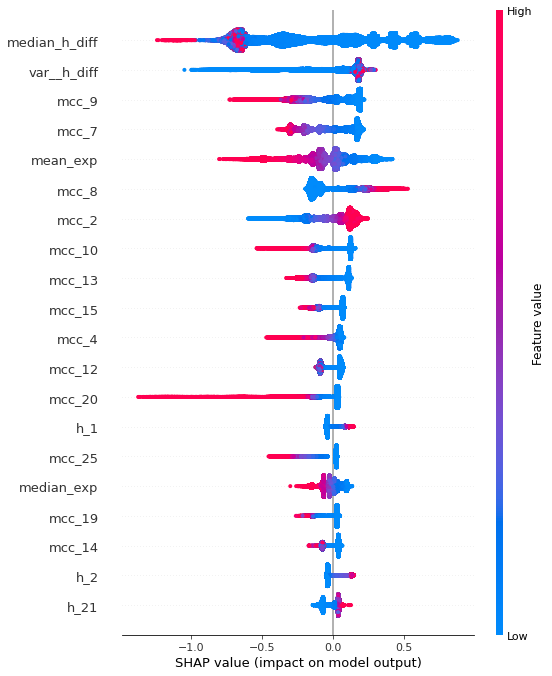

In [313]:
shap.summary_plot(shap_values, X_val)

1. Уменьшение трат в категориях mcc 9, 7, 10, 13, 15, 4, 12, 20, 25, 19 и 14 ассоциируется с большей вероятностью дефолта

2. Уменьшение времени между операциями и повышение его разброса приводят к росту целевой переменной

3. Снижение показателей общих трат приводит к увеличению вероятности дефолта

4. Повышенная активность в позднее время ассоциируется с большей вероятностью дефолта